# Laboratorio 6: Algoritmos Genéticos para Resolución de Problemas Complejos

#### Ignacio Chaparro - 202220577
#### Mateo Lopez - 202220119

## Problema 1: Corridor Crawler (Laberinto Determinístico)

En este problema, los estudiantes asumen el rol de ingenieros de robótica contratados para automatizar una instalación postal subterránea. La tarea inmediata consiste en desarrollar un robot de tipo micromouse que pueda salir de un laberinto fijo de 20 × 20 lo más rápido posible. El objetivo es evolucionar una estrategia de navegación (conjunto de reglas o secuencia de movimientos) que permita al robot encontrar la salida del laberinto de manera eficiente, minimizando el número de pasos y evitando colisiones con parede


Inicialmente, procederemos con la carga de un caso a resolver el caso base.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()
    
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

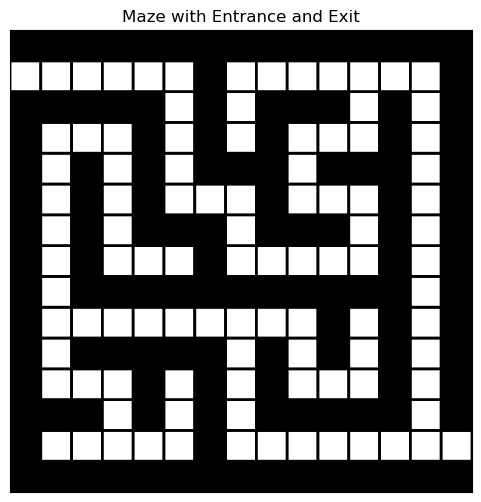

Dimensiones del Laberinto:  (15, 15)


In [9]:
maze = load_maze('maze_case_base.txt')
# maze = load_maze('maze_case_heavy.txt')
display_maze(maze)
print("Dimensiones del Laberinto: ", maze.shape)

Ya con el laberinto cargado, procederemos con la implementación del algoritmo genético para la resolución del problema

Primero deberemos definir la manera en que vamos a representar los cromosomas. En nuestro caso, cada gen va a ser un entero de 0 - 3 

| Numero | Movimiento |
|--------|------------|
| 0 | UP |
| 1 | DOWN |
| 2 | LEFT |
| 3 | RIGHT |

 que va representar la serie de pasos que va a tomar el individuo para navegar por el laberinto. Estos cromosomas van a tener una longitud maxima, correspondiente a las dimensiones del tablero $L * W$.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ─────────────────────────────────────────────────────
# 1) Carga y perímetro
# ─────────────────────────────────────────────────────
def load_maze(path):
    """Carga un laberinto desde un .txt con 0=pasillo, 1=muro."""
    return np.loadtxt(path, dtype=int)

# ─────────────────────────────────────────────────────
# 2) Representación y operadores genéticos
# ─────────────────────────────────────────────────────
MOVES = {
    0: (-1,  0),  # UP
    1: (+1,  0),  # DOWN
    2: ( 0, -1),  # LEFT
    3: ( 0, +1),  # RIGHT
}

def crear_individuo(L_max, start, goal):
    """Genera ruta aleatoria de longitud entre Manhattan*slack y L_max."""
    manh = abs(start[0]-goal[0]) + abs(start[1]-goal[1])
    length = random.randint(manh, L_max)
    return [random.randint(0, 3) for _ in range(length)]

def crossover_one_point(p1, p2, L_max):
    """One-point crossover seguro para cromosomas variables."""
    if len(p1) < 2 or len(p2) < 2:
        return p1[:L_max].copy(), p2[:L_max].copy()
    i = random.randint(1, len(p1)-1)
    j = random.randint(1, len(p2)-1)
    h1 = (p1[:i] + p2[j:])[:L_max]
    h2 = (p2[:j] + p1[i:])[:L_max]
    return h1, h2

def mutar(ind, L_max, p_sub=0.1, p_ins=0.05, p_del=0.05):
    """Sustitución, inserción y borrado con chequeos de rango."""
    # Sustitución
    if len(ind) > 0 and random.random() < p_sub:
        ind[random.randrange(len(ind))] = random.randint(0,3)
    # Inserción
    if len(ind) < L_max and random.random() < p_ins:
        idx = random.randrange(len(ind)+1)
        ind.insert(idx, random.randint(0,3))
    # Borrado
    if len(ind) > 1 and random.random() < p_del:
        ind.pop(random.randrange(len(ind)))
    return ind

# ─────────────────────────────────────────────────────
# 3) Simulación y fitness
# ─────────────────────────────────────────────────────
def is_valid(pos, maze):
    r, c = pos
    R, C = maze.shape
    return 0 <= r < R and 0 <= c < C and maze[r, c] == 0

def simulate(ind, maze, start, goal):
    """Ejecuta la ruta; devuelve pasos, colisiones, reached, final_pos."""
    pos = start
    pasos = col = 0
    for g in ind:
        dr, dc = MOVES[g]
        nxt = (pos[0]+dr, pos[1]+dc)
        if is_valid(nxt, maze):
            pos = nxt
        else:
            col += 1
        pasos += 1
        if pos == goal:
            return pasos, col, True, goal
    return pasos, col, False, pos

def fitness(ind, maze, start, goal,
            pen_col=10, pen_dist=1, pen_exit=1e6):
    """
    - Si llega: fitness = pasos + col·colisiones
    - Si no llega: fitness = exit + dist·Manhattan(final,goal)
    """
    pasos, col, reached, final = simulate(ind, maze, start, goal)
    if reached:
        return pasos + pen_col * col
    manh = abs(final[0]-goal[0]) + abs(final[1]-goal[1])
    return pen_exit + pen_dist * manh

# ─────────────────────────────────────────────────────
# 4) Selección
# ─────────────────────────────────────────────────────
def tournament_selection(pop, fits, k=3):
    aspir = random.sample(list(zip(pop, fits)), k)
    return min(aspir, key=lambda x: x[1])[0]

# ─────────────────────────────────────────────────────
# 5) Bucle GA
# ─────────────────────────────────────────────────────
def run_ga(maze, start, goal,
           pop_size, n_gen,
           cxpb, mutpb):
    R, C = maze.shape
    L_max = R * C

    # 1) Inicializa población
    pop = [crear_individuo(L_max, start, goal) for _ in range(pop_size)]
    fits = [fitness(ind, maze, start, goal) for ind in pop]

    # 2) Guarda el mejor hasta ahora
    best_idx = int(np.argmin(fits))
    best_ind = pop[best_idx].copy()
    best_fit = fits[best_idx]

    # 3) Evolución
    history = [best_fit]
    for gen in range(1, n_gen+1):
        new_pop = [best_ind.copy()]  # elitismo

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fits)
            p2 = tournament_selection(pop, fits)
            if random.random() < cxpb:
                c1, c2 = crossover_one_point(p1, p2, L_max)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if random.random() < mutpb:
                c1 = mutar(c1, L_max)
            if random.random() < mutpb:
                c2 = mutar(c2, L_max)

            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = new_pop
        fits = [fitness(ind, maze, start, goal) for ind in pop]

        idx = int(np.argmin(fits))
        if fits[idx] < best_fit:
            best_fit = fits[idx]
            best_ind = pop[idx].copy()

        history.append(best_fit)

        pasos, col, reached, _ = simulate(best_ind, maze, start, goal)
        if reached:
            print(f"Solved in gen={gen}, pasos={pasos}, colisiones={col}")
            break

    return best_ind, best_fit, history

# ─────────────────────────────────────────────────────
# 6) Visualización
# ─────────────────────────────────────────────────────
def display_solution(maze, route, start, goal):
    R, C = maze.shape

    # Dibuja base blanco/negro
    cmap = ListedColormap(['white','black'])
    plt.figure(figsize=(6,6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=1)
    plt.gca().set_aspect('equal')
    plt.xticks([]); plt.yticks([])

    # Reconstruye camino
    pos = start
    path = [pos]
    for g in route:
        dr, dc = MOVES[g]
        nxt = (pos[0]+dr, pos[1]+dc)
        if is_valid(nxt, maze):
            pos = nxt
        path.append(pos)
        if pos == goal:
            break

    xs = [c+0.5 for r,c in path]
    ys = [(R-1-r)+0.5 for r,c in path]
    plt.plot(xs, ys, '-r', linewidth=2, marker='o', markersize=4)
    plt.scatter([xs[0], xs[-1]], [ys[0], ys[-1]],
                c='green', s=100, zorder=3)

    plt.title('Maze + Solution Path')
    plt.show()



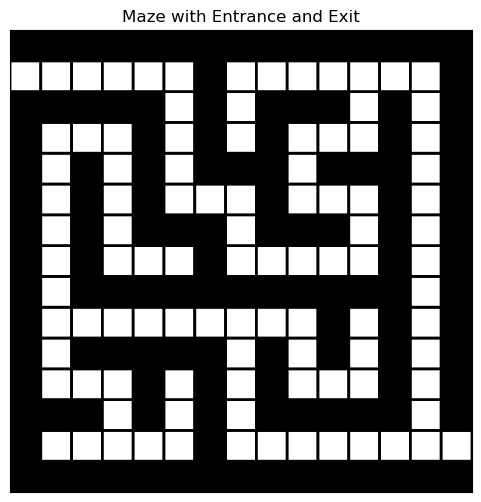

Solved in gen=6, pasos=202, colisiones=100
Mejor fitness: 1202


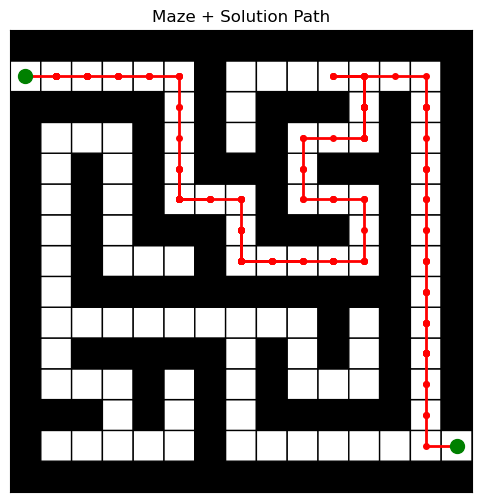

In [63]:
maze = load_maze("maze_case_base.txt")
display_maze(maze)
R, C = maze.shape
start = (1, 0)
goal  = (R-2, C-1)

POP_SIZE=300
N_GEN=200
CXPB=0.7
MUTPB=0.2

best_route, best_fit, hist = run_ga(maze, start, goal, POP_SIZE, N_GEN, CXPB, MUTPB)

print("Mejor fitness:", best_fit)
display_solution(maze, best_route, start, goal)

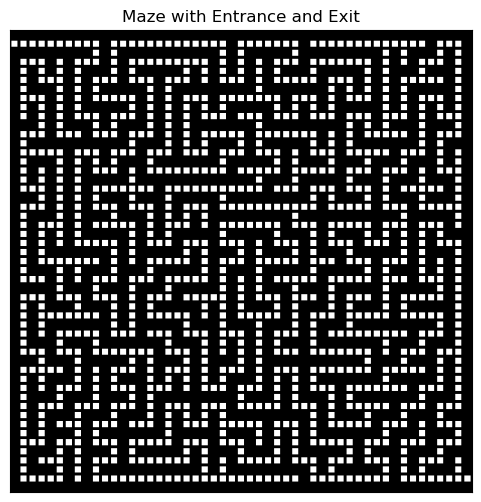

Mejor fitness: 1000053.0


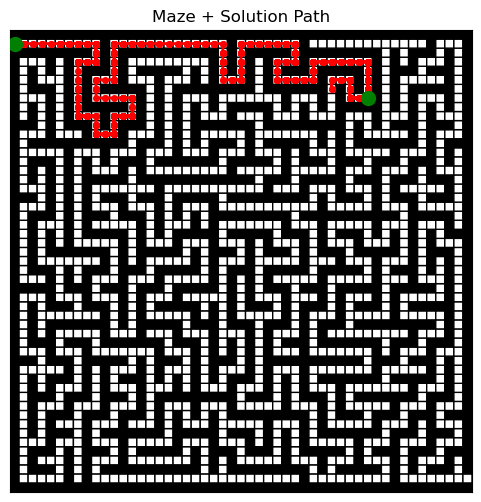

In [64]:
maze = load_maze("maze_case_heavy.txt")
display_maze(maze)
R, C = maze.shape
start = (1, 0)
goal  = (R-2, C-1)

POP_SIZE=500
N_GEN=200
CXPB=0.7
MUTPB=0.2

best_route, best_fit, hist = run_ga(maze, start, goal, POP_SIZE, N_GEN, CXPB, MUTPB)

print("Mejor fitness:", best_fit)
display_solution(maze, best_route, start, goal)

## Explicación de la creación de individuos

Para representar cada posible solución, definimos un **individuo** como una lista de enteros en el rango \[0, 3], donde cada número codifica un movimiento (0=UP, 1=DOWN, 2=LEFT, 3=RIGHT). La longitud de esa lista se elige de forma **variable** entre un mínimo y un máximo:

* El **mínimo** se basa en la distancia Manhattan entre la entrada, asegurando que el individuo tenga pasos suficientes para llegar sin ser excesivamente corto.
* El **máximo** corresponde al número total de celdas (`R×C`), de modo que ninguna ruta pueda superar la exploración completa del laberinto.
  Esta flexibilidad permite generar rutas que se adapten tanto a laberintos pequeños como muy grandes, concentrando la búsqueda en trayectorias plausibles.

## Explicación de la creación de la función de crossover

Para combinar dos padres y generar descendencia, utilizamos un **cruce de un punto** seguro. Primero comprobamos si ambos cromosomas tienen al menos dos genes: si no, simplemente copiamos cada padre truncándolo al tamaño máximo. Si tienen longitud suficiente, elegimos al azar un punto de corte en cada cromosoma (`i` en padre A y `j` en padre B) y creamos dos hijos concatenando A\[:i] + B\[j:] y B\[:j] + A\[i:]. Finalmente truncamos cada hijo a la longitud `L_max`. Este método mantiene segmentos completos de cada padre y asegura que la longitud resultante nunca exceda el límite permitido.

## Explicación de la creación de la función de mutación

La **mutación** introduce diversidad aplicando tres operaciones con probabilidades independientes:

1. **Sustitución**: reemplazar un gen aleatorio por otro movimiento aleatorio, si el individuo no está vacío.
2. **Inserción**: insertar un nuevo movimiento en una posición aleatoria, siempre que la longitud actual sea menor que `L_max`.
3. **Borrado**: eliminar un gen en una posición aleatoria, mientras la longitud sea mayor que 1.
   Al controlar cuidadosamente los rangos (por ejemplo, no sustituir si el cromosoma está vacío), evitamos errores y garantizamos que las mutaciones produzcan rutas válidas y de longitud variable.

## Explicación de la simulación y la función de fitness

Para evaluar cada ruta, simulamos el avance paso a paso a partir de la **posición de inicio**:

* Por cada gen, calculamos la siguiente celda mediante un mapeo de movimientos y comprobamos si es válida (dentro de límites y sin muro).
* Acumulamos **pasos** y **choques** (colisiones contra muros), y detenemos la simulación si se alcanza la salida.
  La función de **fitness** distingue dos casos:
* Si llega a la salida, devuelve `pasos + λ_col·choques`, premiando rutas rápidas y limpias.
* Si no llega, asigna una gran constante `λ_exit` más `λ_dist·distanciaManhattan(final, goal)`, para priorizar individuos que se aproximen al objetivo antes de buscar caminos completos.

## Explicación de la selección por torneo

La **selección por torneo** elige aleatoriamente `k` candidatos de la población y escoge el que tenga el **menor fitness** (mejor puntuación). Este mecanismo, al repetirse para cada padre, promueve la supervivencia de soluciones más aptas y mantiene un equilibrio entre **presión selectiva** (seleccionar buenos individuos) y **diversidad** (la muestra aleatoria en cada torneo).

## Explicación del bucle principal del algoritmo genético

El **bucle evolutivo** sigue estos pasos en cada generación:

1. **Elitismo**: copiamos directamente el mejor individuo de la generación anterior.
2. **Reproducción**: hasta completar el tamaño de población, repetimos—selección por torneo, cruce (o copia directa) y mutación—para generar nuevos hijos.
3. **Evaluación**: recalculamos el fitness de todos los individuos.
4. **Actualización del mejor**: si aparece un individuo con fitness menor, lo guardamos como nuevo élite.
5. **Parada temprana**: si el élite alcanza la salida, detenemos la ejecución antes de llegar al número máximo de generaciones.
   Este ciclo garantiza convergencia hacia rutas cada vez mejores, manteniendo siempre al menos un ejemplar de la mejor solución encontrada.


## Conclusiones

En el **caso base**, el algoritmo genético encontró una ruta válida muy rápidamente, alcanzando la salida en la generación 6. El mejor individuo dio **202 pasos** con **100 colisiones**, lo que resultó en un fitness de **1 202**. Este resultado muestra que, gracias a la longitud mínima garantizada en la creación de la población y a la función de fitness que castiga las colisiones y premia la llegada, el GA convergió rápidamente hacia soluciones factibles. La selección por torneo permitió explotar las rutas más cortas y limpias, mientras que un moderado porcentaje de mutación e intercambio de genes mantuvo suficiente diversidad para escapar de óptimos locales.

En el **caso grande**, en cambio, el GA no logró resolver el laberinto antes de agotar las generaciones máximas. Esto se debe principalmente a que el espacio de búsqueda crece exponencialmente con el tamaño: más muros y giros implican rutas más largas y complejas, lo que crea un “plateau” donde muchos individuos permanecen a la misma distancia de la meta. Además, el elitismo fuerte y las bajas tasas iniciales de mutación pueden haber fijado prematuramente la población en trayectorias subóptimas, sin la variedad suficiente para explorar caminos alternativos. Para abordar este desafío sería necesario ajustar parámetros (mayor población, mutación más agresiva, cruces más variados) y considerar heurísticas híbridas (por ejemplo, rutas semilla generadas por BFS o A\*) que guíen el GA en el laberinto más grande.
